In [2]:
import pandas as pd
import numpy as np
import darts
import yfinance as yf

# visualization
import matplotlib.pyplot as plt

# timeseries with darts
import torch
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts import concatenate


# RF model test with Covariate
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# darts model evaluation
from darts.metrics import mape, rmse, r2_score
from darts.models import TransformerModel

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
# Data preparation for model development

df =pd.read_csv(r'C:\Users\dicod\Documents\2024\project_with Hamid(2024_3rd semester)\code\Data\final_df.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date'] = df['Date'].apply(lambda x:x[0:10])
df['Date'] = pd.to_datetime(df['Date'])


# dataframe to timeseries
ts_price = TimeSeries.from_dataframe(df, time_col=None, value_cols='Close', fill_missing_dates=False, freq='D')
ts_Volume = TimeSeries.from_dataframe(df, time_col=None, value_cols='Volume', fill_missing_dates=False, freq='D')
ts_EPS = TimeSeries.from_dataframe(df, time_col=None, value_cols='EPS', fill_missing_dates=False, freq='D')
ts_PE = TimeSeries.from_dataframe(df, time_col=None, value_cols='P/E', fill_missing_dates=False, freq='D')
ts_PS = TimeSeries.from_dataframe(df, time_col=None, value_cols='P/S', fill_missing_dates=False, freq='D')

# scaler
scaler = Scaler()
scaled_price, scaled_Volume, scaled_EPS, scaled_PE, scaled_PS = scaler.fit_transform([ts_price, ts_Volume, ts_EPS, ts_PE, ts_PS] )

my_multivariate_series = concatenate([scaled_price, scaled_Volume, scaled_EPS, scaled_PE, scaled_PS], axis=1)

# split the data into train and validation
train, validation = my_multivariate_series.split_after(0.8)

# define the covarients using train and validation data
past_cov = my_multivariate_series['Volume']
past_cov_fn = my_multivariate_series[['Volume', 'EPS', 'P/E', 'P/S']]

past_cov_train_vol = train['Volume']
past_cov_val_vol = validation['Volume']

past_cov_train_fn = train[['Volume', 'EPS', 'P/E', 'P/S']]
past_cov_val_fn = validation[['Volume', 'EPS', 'P/E', 'P/S']]

In [5]:
print(len(validation['Close']))

238


In [7]:
print(len(past_cov_val_vol))

238


hyper parameter!

nhead=2, 4, 8, 16
num_encoder_layer = 3, 4, 5, 7
num_decoder_layers=3 ,4, 5, 7
e_epoch = 10, 20, 30, 50

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 10.0 K
4 | fc            | Sequential       | 260   
---------------------------------------------------
10.2 K    Trainable params
0         Non-trainable params
10.2 K    Total params
0.041     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

GRU RMSE = 46.92
GRU R2 = -0.83
GRU MAPE = 9.82


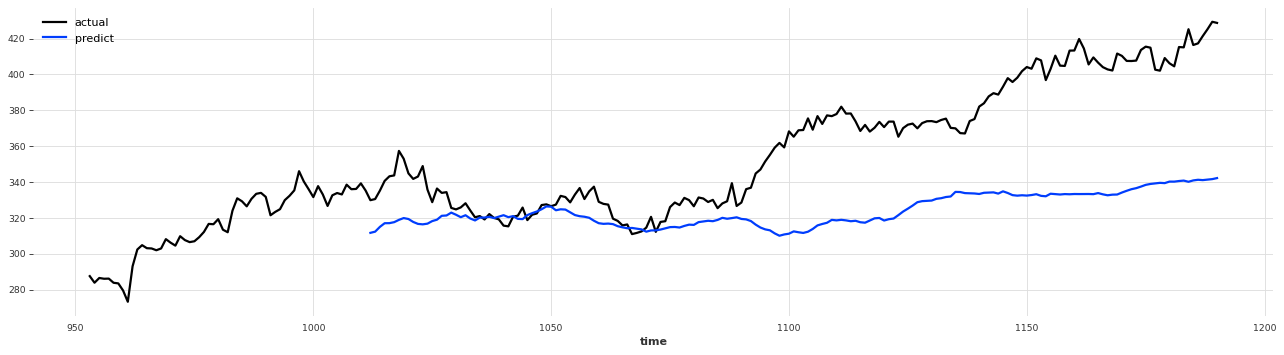

In [5]:
from darts.models import BlockRNNModel
gru = BlockRNNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    model ="GRU",
    hidden_dim=25, n_rnn_layers=3,  #dropout=0.02,
    n_epochs=50
)
gru.fit(train['Close'], past_covariates=past_cov_train_vol)

gru_pred = gru.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=30,
    past_covariates=past_cov_val_vol,
    retrain=False,
    verbose=False)

actual_pris = scaler.inverse_transform(validation['Close']) 
pred_pris = scaler.inverse_transform(gru_pred) 

trans_v1_act_rmse = rmse(actual_pris, pred_pris)
trans_v1_act__r2 = r2_score(actual_pris, pred_pris)
trans_v1_act_mape = mape(actual_pris, pred_pris)
print("GRU RMSE = %.2f" % trans_v1_act_rmse)
print("GRU R2 = %.2f" % trans_v1_act__r2)
print("GRU MAPE = %.2f" % trans_v1_act_mape)

plt.figure(figsize=(20, 5), dpi=80)
actual_pris['Close'].plot(label="actual")
pred_pris.plot(label="predict")
plt.show()


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 84.6 K
4 | fc            | Sequential       | 510   
---------------------------------------------------
85.1 K    Trainable params
0         Non-trainable params
85.1 K    Total params
0.340     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

GRU2 RMSE = 56.87
GRU2 R2 = -1.69
GRU2 MAPE = 12.79


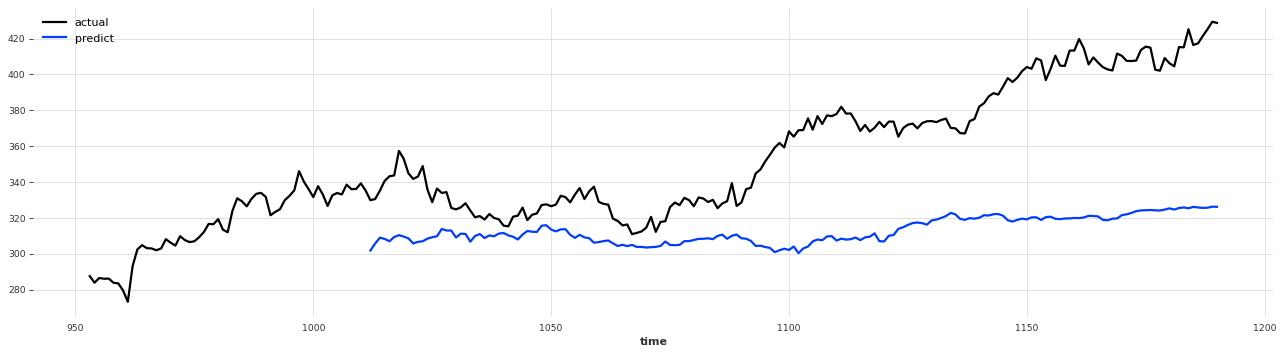

In [4]:
from darts.models import BlockRNNModel
gru = BlockRNNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    model ="GRU",
    hidden_dim=50, n_rnn_layers=6,  #dropout=0.02,
    n_epochs=50
)
gru.fit(train['Close'], past_covariates=past_cov_train_vol)

gru_pred = gru.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=30,
    past_covariates=past_cov_val_vol,
    retrain=False,
    verbose=False)

actual_pris = scaler.inverse_transform(validation['Close']) 
pred_pris = scaler.inverse_transform(gru_pred) 

trans_v1_act_rmse = rmse(actual_pris, pred_pris)
trans_v1_act__r2 = r2_score(actual_pris, pred_pris)
trans_v1_act_mape = mape(actual_pris, pred_pris)
print("GRU2 RMSE = %.2f" % trans_v1_act_rmse)
print("GRU2 R2 = %.2f" % trans_v1_act__r2)
print("GRU2 MAPE = %.2f" % trans_v1_act_mape)

plt.figure(figsize=(20, 5), dpi=80)
actual_pris['Close'].plot(label="actual")
pred_pris.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 192   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 1.9 K 
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.203     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 70.30
R2 = -3.09
MAPE = 16.04


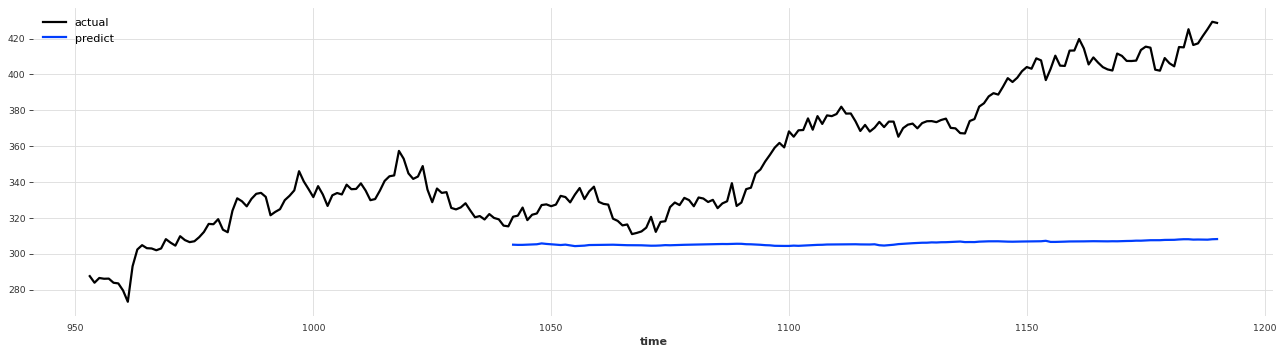

In [7]:

trans_v1 = TransformerModel(
    input_chunk_length=60,
    output_chunk_length=30,
    d_model=64, nhead=2, num_encoder_layers=3, num_decoder_layers=3,
    n_epochs=10
)
trans_v1.fit(train['Close'], past_covariates=past_cov_train_vol)

pred_trans = trans_v1.predict(30, past_covariates=past_cov_train_vol)
pred_trans_pris = scaler.inverse_transform(pred_trans)

trans_v1_pred_series = trans_v1.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=30,
    past_covariates=past_cov_val_vol,
    retrain=False,
    verbose=False)

# that is why I have an error.
# It is not the same as forecast horizon n used in predict(), 
# which is the desired number of prediction points generated using either a one-shot- or autoregressive forecast. 
# Setting n <= output_chunk_length prevents auto-regression. 

# actual price compare to pred_par1_pris
actual_pris = scaler.inverse_transform(validation['Close']) 
pred_pris = scaler.inverse_transform(trans_v1_pred_series) 

trans_v1_act_rmse = rmse(actual_pris, pred_pris)
trans_v1_act__r2 = r2_score(actual_pris, pred_pris)
trans_v1_act_mape = mape(actual_pris, pred_pris)
print("RMSE = %.2f" % trans_v1_act_rmse)
print("R2 = %.2f" % trans_v1_act__r2)
print("MAPE = %.2f" % trans_v1_act_mape)

plt.figure(figsize=(20, 5), dpi=80)
actual_pris['Close'].plot(label="actual")
pred_pris.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 192   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 731 K 
6 | decoder             | Linear              | 1.9 K 
------------------------------------------------------------
733 K     Trainable params
0         Non-trainable params
733 K     Total params
2.934     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 52.01
R2 = -1.24
MAPE = 10.84


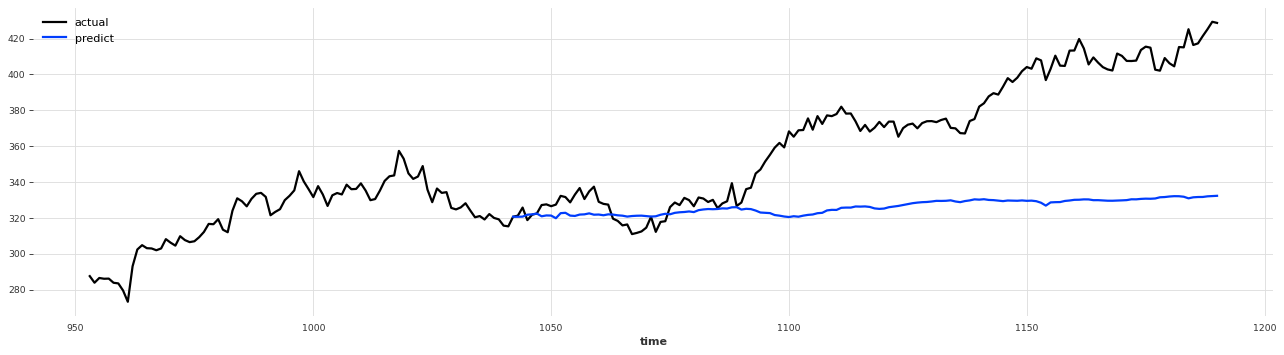

In [8]:
trans_v2 = TransformerModel(
    input_chunk_length=60,
    output_chunk_length=30,
    d_model=64, nhead=4, num_encoder_layers=4, num_decoder_layers=4,
    n_epochs=20
)
trans_v2.fit(train['Close'], past_covariates=past_cov_train_vol)

pred_trans = trans_v2.predict(30, past_covariates=past_cov_train_vol)
pred_trans_pris = scaler.inverse_transform(pred_trans)

trans_v2_pred_series = trans_v2.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=30,
    past_covariates=past_cov_val_vol,
    retrain=False,
    verbose=False)

# that is why I have an error.
# It is not the same as forecast horizon n used in predict(), 
# which is the desired number of prediction points generated using either a one-shot- or autoregressive forecast. 
# Setting n <= output_chunk_length prevents auto-regression. 

# actual price compare to pred_par1_pris
actual_pris = scaler.inverse_transform(validation['Close']) 
pred_pris = scaler.inverse_transform(trans_v2_pred_series) 

trans_v2_act_rmse = rmse(actual_pris, pred_pris)
trans_v2_act__r2 = r2_score(actual_pris, pred_pris)
trans_v2_act_mape = mape(actual_pris, pred_pris)
print("RMSE = %.2f" % trans_v2_act_rmse)
print("R2 = %.2f" % trans_v2_act__r2)
print("MAPE = %.2f" % trans_v2_act_mape)

plt.figure(figsize=(20, 5), dpi=80)
actual_pris['Close'].plot(label="actual")
pred_pris.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 192   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 914 K 
6 | decoder             | Linear              | 1.9 K 
------------------------------------------------------------
916 K     Trainable params
0         Non-trainable params
916 K     Total params
3.665     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 66.85
R2 = -2.70
MAPE = 15.13


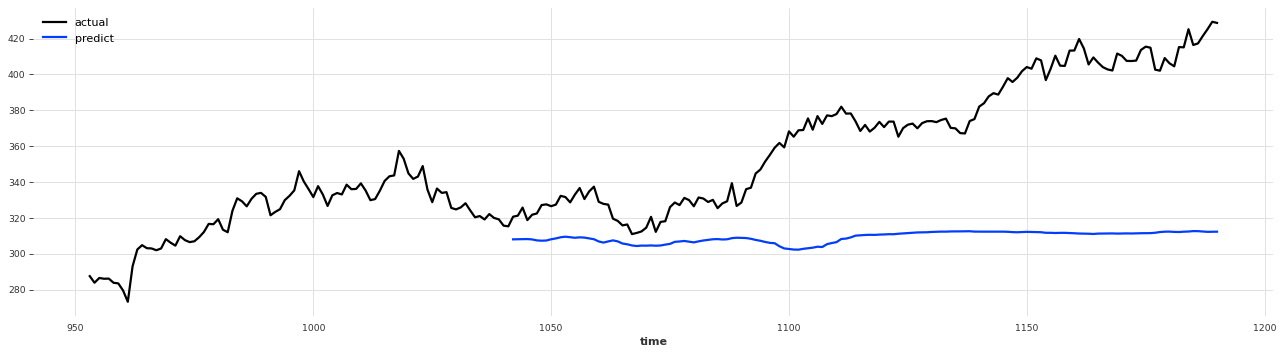

In [9]:
trans_v3 = TransformerModel(
    input_chunk_length=60,
    output_chunk_length=30,
    d_model=64, nhead=8, num_encoder_layers=5, num_decoder_layers=5,
    n_epochs=30
)
trans_v3.fit(train['Close'], past_covariates=past_cov_train_vol)

pred_trans = trans_v3.predict(30, past_covariates=past_cov_train_vol)
pred_trans_pris = scaler.inverse_transform(pred_trans)

trans_v3_pred_series = trans_v3.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=30,
    past_covariates=past_cov_val_vol,
    retrain=False,
    verbose=False)

# that is why I have an error.
# It is not the same as forecast horizon n used in predict(), 
# which is the desired number of prediction points generated using either a one-shot- or autoregressive forecast. 
# Setting n <= output_chunk_length prevents auto-regression. 

# actual price compare to pred_par1_pris
actual_pris = scaler.inverse_transform(validation['Close']) 
pred_pris = scaler.inverse_transform(trans_v3_pred_series) 

trans_v3_act_rmse = rmse(actual_pris, pred_pris)
trans_v3_act__r2 = r2_score(actual_pris, pred_pris)
trans_v3_act_mape = mape(actual_pris, pred_pris)
print("RMSE = %.2f" % trans_v3_act_rmse)
print("R2 = %.2f" % trans_v3_act__r2)
print("MAPE = %.2f" % trans_v3_act_mape)

plt.figure(figsize=(20, 5), dpi=80)
actual_pris['Close'].plot(label="actual")
pred_pris.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 192   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 1.3 M 
6 | decoder             | Linear              | 1.9 K 
------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.128     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 94.03
R2 = -6.32
MAPE = 23.09


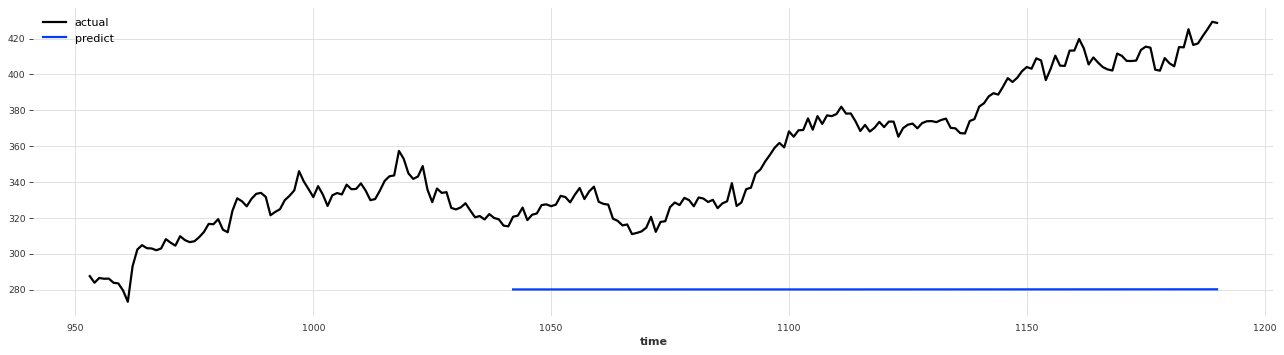

In [10]:
trans_v4 = TransformerModel(
    input_chunk_length=60,
    output_chunk_length=30,
    d_model=64, nhead=16, num_encoder_layers=7, num_decoder_layers=7,
    n_epochs=50
)
trans_v4.fit(train['Close'], past_covariates=past_cov_train_vol)

pred_trans = trans_v4.predict(30, past_covariates=past_cov_train_vol)
pred_trans_pris = scaler.inverse_transform(pred_trans)

trans_v4_pred_series = trans_v4.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=30,
    past_covariates=past_cov_val_vol,
    retrain=False,
    verbose=False)

# that is why I have an error.
# It is not the same as forecast horizon n used in predict(), 
# which is the desired number of prediction points generated using either a one-shot- or autoregressive forecast. 
# Setting n <= output_chunk_length prevents auto-regression. 

# actual price compare to pred_par1_pris
actual_pris = scaler.inverse_transform(validation['Close']) 
pred_pris = scaler.inverse_transform(trans_v4_pred_series) 

trans_v4_act_rmse = rmse(actual_pris, pred_pris)
trans_v4_act__r2 = r2_score(actual_pris, pred_pris)
trans_v4_act_mape = mape(actual_pris, pred_pris)
print("RMSE = %.2f" % trans_v4_act_rmse)
print("R2 = %.2f" % trans_v4_act__r2)
print("MAPE = %.2f" % trans_v4_act_mape)

plt.figure(figsize=(20, 5), dpi=80)
actual_pris['Close'].plot(label="actual")
pred_pris.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 384   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 1.9 K 
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.204     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 48.75
R2 = -0.97
MAPE = 10.13


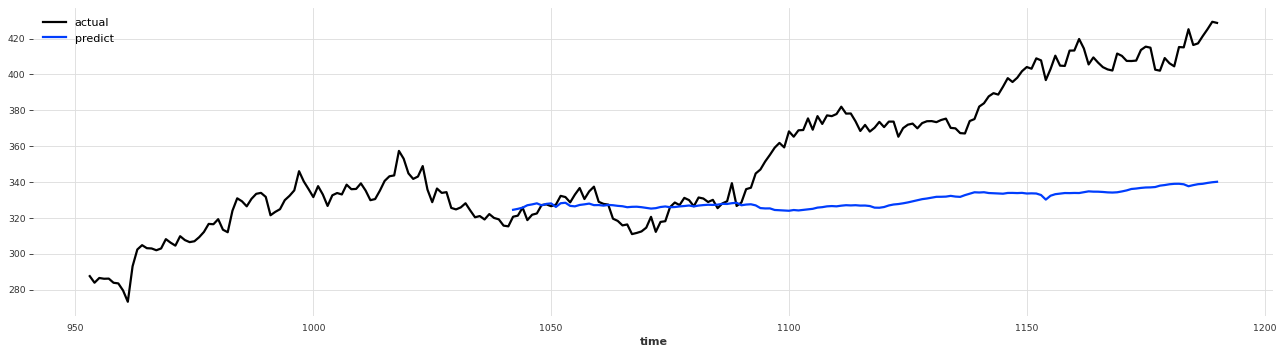

In [12]:
trans_withfn_v1 = TransformerModel(
    input_chunk_length=60,
    output_chunk_length=30,
    d_model=64, nhead=2, num_encoder_layers=3, num_decoder_layers=3,
    n_epochs=10
)
trans_withfn_v1.fit(train['Close'], past_covariates=past_cov_train_fn)

pred_trans = trans_withfn_v1.predict(30, past_covariates=past_cov_train_fn)
pred_trans_pris = scaler.inverse_transform(pred_trans)

trans_withfn_v1_pred_series = trans_withfn_v1.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=30,
    past_covariates=past_cov_val_fn,
    retrain=False,
    verbose=False)

# that is why I have an error.
# It is not the same as forecast horizon n used in predict(), 
# which is the desired number of prediction points generated using either a one-shot- or autoregressive forecast. 
# Setting n <= output_chunk_length prevents auto-regression. 

# actual price compare to pred_par1_pris
actual_pris = scaler.inverse_transform(validation['Close']) 
pred_pris = scaler.inverse_transform(trans_withfn_v1_pred_series) 

trans_withfn_v1_rmse = rmse(actual_pris, pred_pris)
trans_withfn_v1__r2 = r2_score(actual_pris, pred_pris)
trans_withfn_v1_mape = mape(actual_pris, pred_pris)
print("RMSE = %.2f" % trans_withfn_v1_rmse)
print("R2 = %.2f" % trans_withfn_v1__r2)
print("MAPE = %.2f" % trans_withfn_v1_mape)

plt.figure(figsize=(20, 5), dpi=80)
actual_pris['Close'].plot(label="actual")
pred_pris.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 384   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 731 K 
6 | decoder             | Linear              | 1.9 K 
------------------------------------------------------------
733 K     Trainable params
0         Non-trainable params
733 K     Total params
2.935     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 84.12
R2 = -4.86
MAPE = 19.53


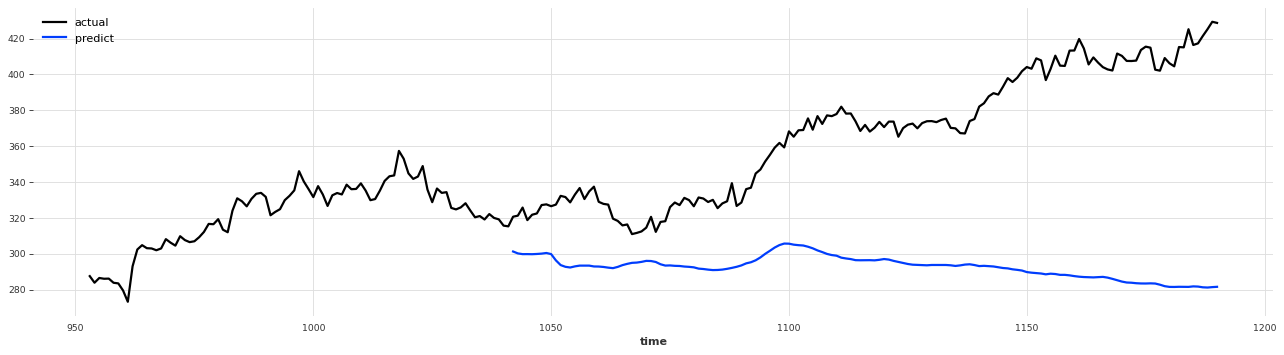

In [13]:
trans_withfn_v2 = TransformerModel(
    input_chunk_length=60,
    output_chunk_length=30,
    d_model=64, nhead=4, num_encoder_layers=4, num_decoder_layers=4,
    n_epochs=20
)
trans_withfn_v2.fit(train['Close'], past_covariates=past_cov_train_fn)

pred_trans = trans_withfn_v2.predict(30, past_covariates=past_cov_train_fn)
pred_trans_pris = scaler.inverse_transform(pred_trans)

trans_withfn_v2_pred_series = trans_withfn_v2.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=30,
    past_covariates=past_cov_val_fn,
    retrain=False,
    verbose=False)

# that is why I have an error.
# It is not the same as forecast horizon n used in predict(), 
# which is the desired number of prediction points generated using either a one-shot- or autoregressive forecast. 
# Setting n <= output_chunk_length prevents auto-regression. 

# actual price compare to pred_par1_pris
actual_pris = scaler.inverse_transform(validation['Close']) 
pred_pris = scaler.inverse_transform(trans_withfn_v2_pred_series) 

trans_withfn_v2_rmse = rmse(actual_pris, pred_pris)
trans_withfn_v2__r2 = r2_score(actual_pris, pred_pris)
trans_withfn_v2_mape = mape(actual_pris, pred_pris)
print("RMSE = %.2f" % trans_withfn_v2_rmse)
print("R2 = %.2f" % trans_withfn_v2__r2)
print("MAPE = %.2f" % trans_withfn_v2_mape)

plt.figure(figsize=(20, 5), dpi=80)
actual_pris['Close'].plot(label="actual")
pred_pris.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 384   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 914 K 
6 | decoder             | Linear              | 1.9 K 
------------------------------------------------------------
916 K     Trainable params
0         Non-trainable params
916 K     Total params
3.666     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 74.13
R2 = -3.55
MAPE = 16.57


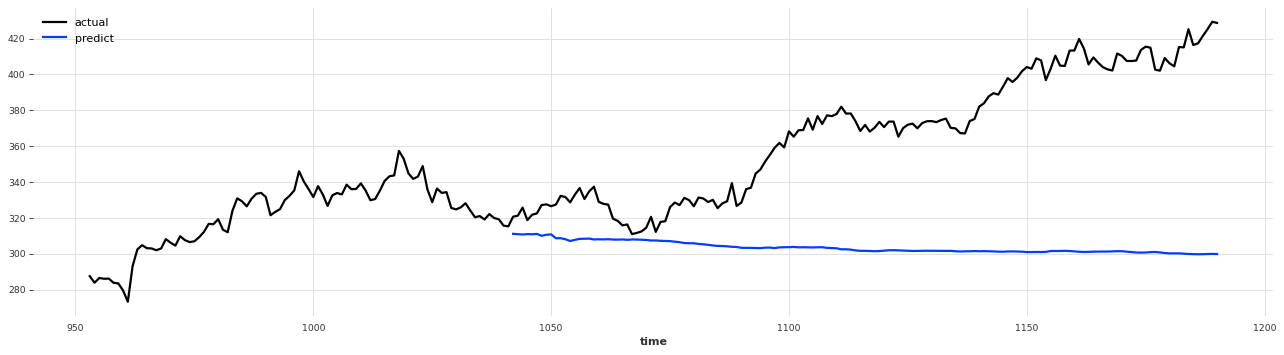

In [14]:
trans_withfn_v3 = TransformerModel(
    input_chunk_length=60,
    output_chunk_length=30,
    d_model=64, nhead=8, num_encoder_layers=5, num_decoder_layers=5,
    n_epochs=30
)
trans_withfn_v3.fit(train['Close'], past_covariates=past_cov_train_fn)

pred_trans = trans_withfn_v3.predict(30, past_covariates=past_cov_train_fn)
pred_trans_pris = scaler.inverse_transform(pred_trans)

trans_withfn_v3_pred_series = trans_withfn_v3.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=30,
    past_covariates=past_cov_val_fn,
    retrain=False,
    verbose=False)

# that is why I have an error.
# It is not the same as forecast horizon n used in predict(), 
# which is the desired number of prediction points generated using either a one-shot- or autoregressive forecast. 
# Setting n <= output_chunk_length prevents auto-regression. 

# actual price compare to pred_par1_pris
actual_pris = scaler.inverse_transform(validation['Close']) 
pred_pris = scaler.inverse_transform(trans_withfn_v3_pred_series) 

trans_withfn_v3_rmse = rmse(actual_pris, pred_pris)
trans_withfn_v3__r2 = r2_score(actual_pris, pred_pris)
trans_withfn_v3_mape = mape(actual_pris, pred_pris)
print("RMSE = %.2f" % trans_withfn_v3_rmse)
print("R2 = %.2f" % trans_withfn_v3__r2)
print("MAPE = %.2f" % trans_withfn_v3_mape)

plt.figure(figsize=(20, 5), dpi=80)
actual_pris['Close'].plot(label="actual")
pred_pris.plot(label="predict")
plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 384   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 1.3 M 
6 | decoder             | Linear              | 1.9 K 
------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.128     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

RMSE = 62.02
R2 = -2.19
MAPE = 13.30


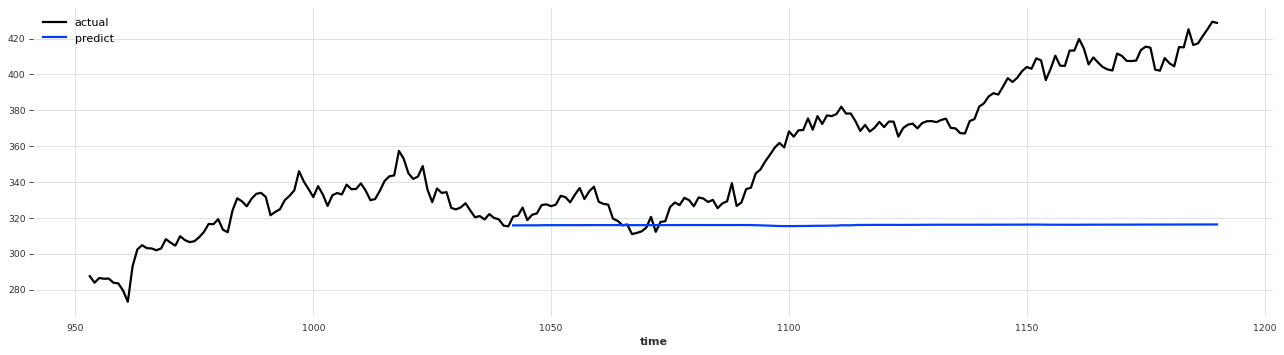

In [15]:
trans_withfn_v4 = TransformerModel(
    input_chunk_length=60,
    output_chunk_length=30,
    d_model=64, nhead=16, num_encoder_layers=7, num_decoder_layers=7,
    n_epochs=50
)
trans_withfn_v4.fit(train['Close'], past_covariates=past_cov_train_fn)

pred_trans = trans_withfn_v4.predict(30, past_covariates=past_cov_train_fn)
pred_trans_pris = scaler.inverse_transform(pred_trans)

trans_withfn_v4_pred_series = trans_withfn_v4.historical_forecasts(
    series=validation['Close'],
    forecast_horizon=30,
    past_covariates=past_cov_val_fn,
    retrain=False,
    verbose=False)

# that is why I have an error.
# It is not the same as forecast horizon n used in predict(), 
# which is the desired number of prediction points generated using either a one-shot- or autoregressive forecast. 
# Setting n <= output_chunk_length prevents auto-regression. 

# actual price compare to pred_par1_pris
actual_pris = scaler.inverse_transform(validation['Close']) 
pred_pris = scaler.inverse_transform(trans_withfn_v4_pred_series) 

trans_withfn_v4_rmse = rmse(actual_pris, pred_pris)
trans_withfn_v4__r2 = r2_score(actual_pris, pred_pris)
trans_withfn_v4_mape = mape(actual_pris, pred_pris)
print("RMSE = %.2f" % trans_withfn_v4_rmse)
print("R2 = %.2f" % trans_withfn_v4__r2)
print("MAPE = %.2f" % trans_withfn_v4_mape)

plt.figure(figsize=(20, 5), dpi=80)
actual_pris['Close'].plot(label="actual")
pred_pris.plot(label="predict")
plt.show()